In [1]:
from google.colab import files
uploaded = files.upload()

Saving sensor1 (1).csv to sensor1 (1).csv


In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
import warnings
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
# Load the model (if not already loaded)
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# Load the data
data = pd.read_csv('sensor1 (1).csv')

# Preprocess the data
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

data.drop(['Humidity', 'PM10', 'PM2.5', 'CO2', 'TVOC'], axis=1, inplace=True)
data['Temperature'] = data['Temperature'].str.split().str[0].astype(float)  # Extract Temperature values

# Drop rows with NaN values
data.dropna(inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Normalize the entire dataset

# Define window size for sequences
window_size = 24

# Prepare sequences
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predicting only CO2, hence [0]
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, window_size)

# Split the data into training and testing sets
split_ratio = 0.8  # 80% for training, 20% for testing
total_sequences = len(X)  # Total number of sequences prepared from your dataset
split_index = int(total_sequences * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the RNN model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),  # Adding dropout for regularization
    LSTM(units=64),
    Dropout(0.2),  # Adding dropout for regularization
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)


Epoch 1/20
18/18 [==============================] - 5s 48ms/step - loss: 0.0979
Epoch 2/20
18/18 [==============================] - 1s 41ms/step - loss: 0.0519
Epoch 3/20
18/18 [==============================] - 0s 28ms/step - loss: 0.0450
Epoch 4/20
18/18 [==============================] - 1s 29ms/step - loss: 0.0351
Epoch 5/20
18/18 [==============================] - 1s 28ms/step - loss: 0.0285
Epoch 6/20
18/18 [==============================] - 1s 29ms/step - loss: 0.0259
Epoch 7/20
18/18 [==============================] - 1s 28ms/step - loss: 0.0238
Epoch 8/20
18/18 [==============================] - 1s 28ms/step - loss: 0.0205
Epoch 9/20
18/18 [==============================] - 1s 30ms/step - loss: 0.0217
Epoch 10/20
18/18 [==============================] - 1s 54ms/step - loss: 0.0204
Epoch 11/20
18/18 [==============================] - 1s 32ms/step - loss: 0.0188
Epoch 12/20
18/18 [==============================] - 1s 29ms/step - loss: 0.0188
Epoch 13/20
18/18 [==================

In [5]:
y_pred = model.predict(X_test)
# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

5/5 [==============================] - 1s 9ms/step


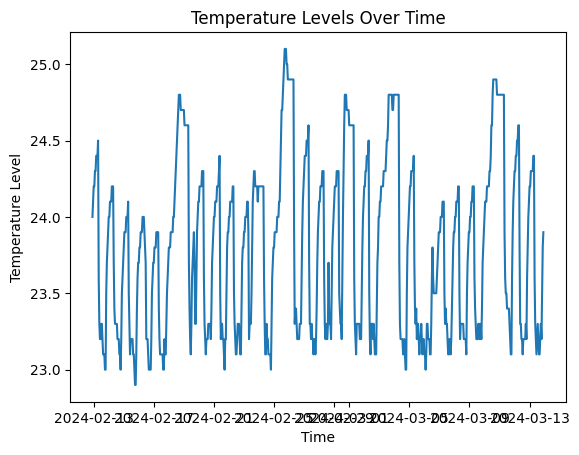

In [6]:
# Visualize the input data
import matplotlib.pyplot as plt

plt.plot(data.index, data['Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature Level')
plt.title('Temperature Levels Over Time')
plt.show()

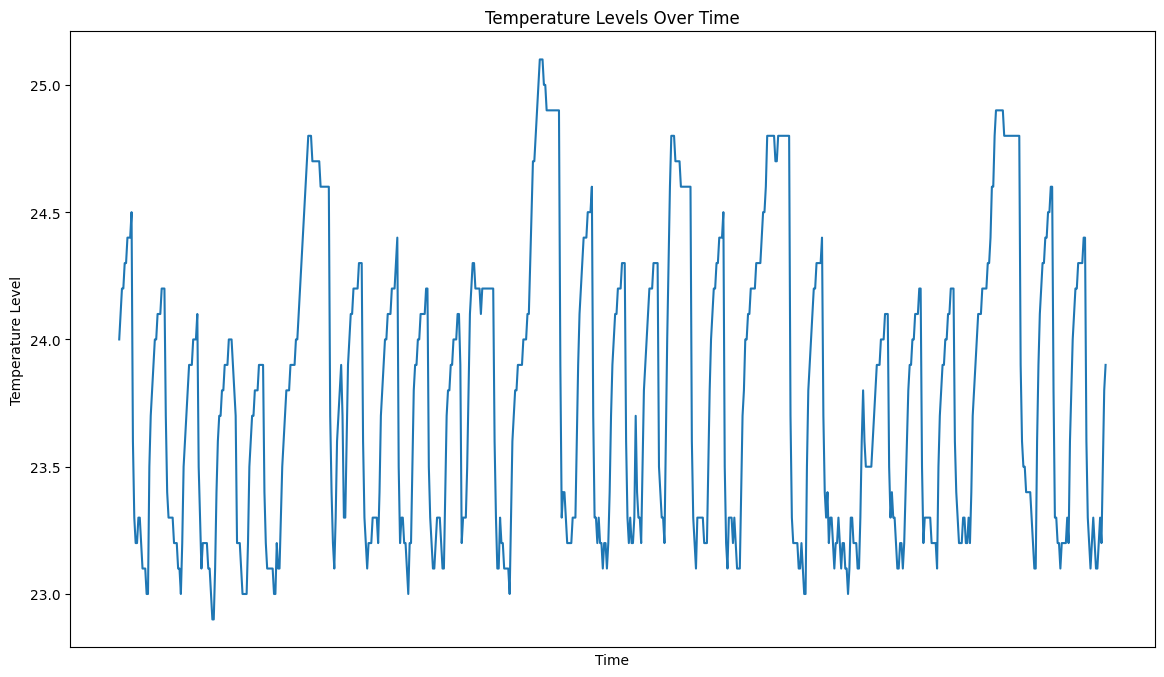

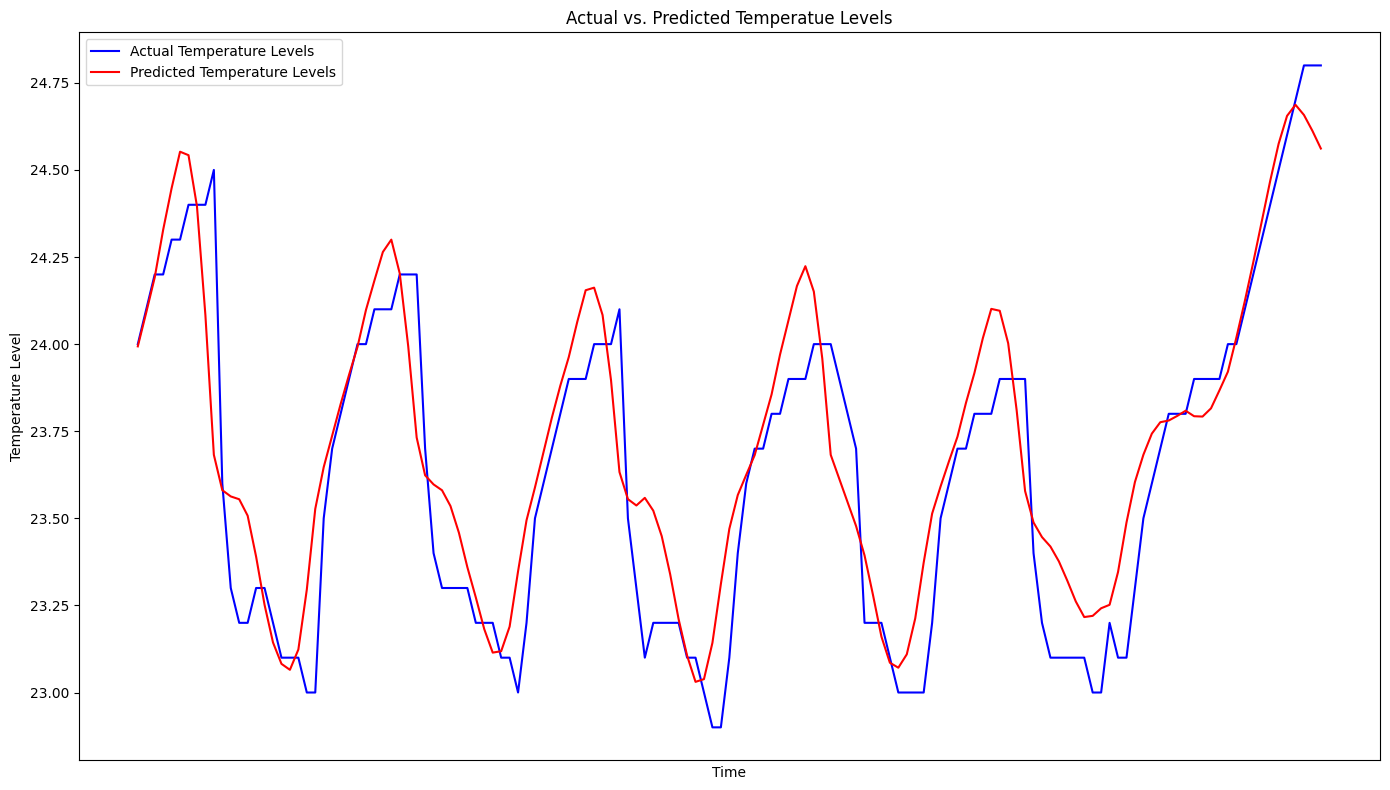

In [7]:
# Visualize the input data
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature Level')
plt.title('Temperature Levels Over Time')

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(data.index[0], data.index[-1], freq='H'), rotation=45)

plt.show()

# Visualize the predictions
plt.figure(figsize=(14, 8))

actual_dates = data.index[-len(y_test_actual):]  # This fetches the dates for the test segment

plt.plot(actual_dates, y_test_actual, label='Actual Temperature Levels', color='blue')
plt.plot(actual_dates, y_pred_actual, label='Predicted Temperature Levels', color='red')

plt.xlabel('Time')
plt.ylabel('Temperature Level')
plt.title('Actual vs. Predicted Temperatue Levels')
plt.legend()

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(actual_dates[0], actual_dates[-1], freq='H'), rotation=45)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()



In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = sqrt(mean_squared_error(y_test_actual, y_pred_actual))  # As calculated previously
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test MAPE: {mape}%')
print(f'Test R-Squared: {r2}')

Test MAE: 0.15262889999279866
Test RMSE: 0.20233182914624323
Test MAPE: 0.6476219781599999%
Test R-Squared: 0.8211187530465098


**Hyperparameters tuning**

In [10]:
!pip install keras
!pip install scikeras

In [11]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

def create_model():
    model = Sequential([
        LSTM(64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [24, 32, 64, 128]
epochs = [20, 50, 65]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.886775 using {'batch_size': 24, 'epochs': 65}


Implementation using optimal parameters

In [12]:


# Load the data
data = pd.read_csv('sensor1 (1).csv')

# Preprocess the data
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

data.drop(['Humidity', 'PM10', 'PM2.5', 'CO2', 'TVOC'], axis=1, inplace=True)
data['Temperature'] = data['Temperature'].str.split().str[0].astype(float)  # Extract Temp values

# Drop rows with NaN values
data.dropna(inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Normalize the entire dataset

# Define window size for sequences
window_size = 24

# Prepare sequences
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predicting only Temp, hence [0]
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, window_size)

# Split the data into training and testing sets
split_ratio = 0.8  # 80% for training, 20% for testing
total_sequences = len(X)  # Total number of sequences prepared from your dataset
split_index = int(total_sequences * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the RNN model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, data_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),  # Adding dropout for regularization
    LSTM(units=64),
    Dropout(0.2),  # Adding dropout for regularization
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=65, batch_size=24, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)


Epoch 1/65
19/19 [==============================] - 7s 82ms/step - loss: 0.1082 - val_loss: 0.0511
Epoch 2/65
19/19 [==============================] - 1s 38ms/step - loss: 0.0548 - val_loss: 0.0420
Epoch 3/65
19/19 [==============================] - 1s 49ms/step - loss: 0.0445 - val_loss: 0.0373
Epoch 4/65
19/19 [==============================] - 1s 49ms/step - loss: 0.0354 - val_loss: 0.0285
Epoch 5/65
19/19 [==============================] - 1s 49ms/step - loss: 0.0305 - val_loss: 0.0236
Epoch 6/65
19/19 [==============================] - 1s 31ms/step - loss: 0.0257 - val_loss: 0.0214
Epoch 7/65
19/19 [==============================] - 1s 31ms/step - loss: 0.0243 - val_loss: 0.0207
Epoch 8/65
19/19 [==============================] - 1s 32ms/step - loss: 0.0222 - val_loss: 0.0203
Epoch 9/65
19/19 [==============================] - 1s 31ms/step - loss: 0.0201 - val_loss: 0.0197
Epoch 10/65
19/19 [==============================] - 1s 31ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 11/

In [13]:
y_pred = model.predict(X_test)
# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

5/5 [==============================] - 1s 10ms/step


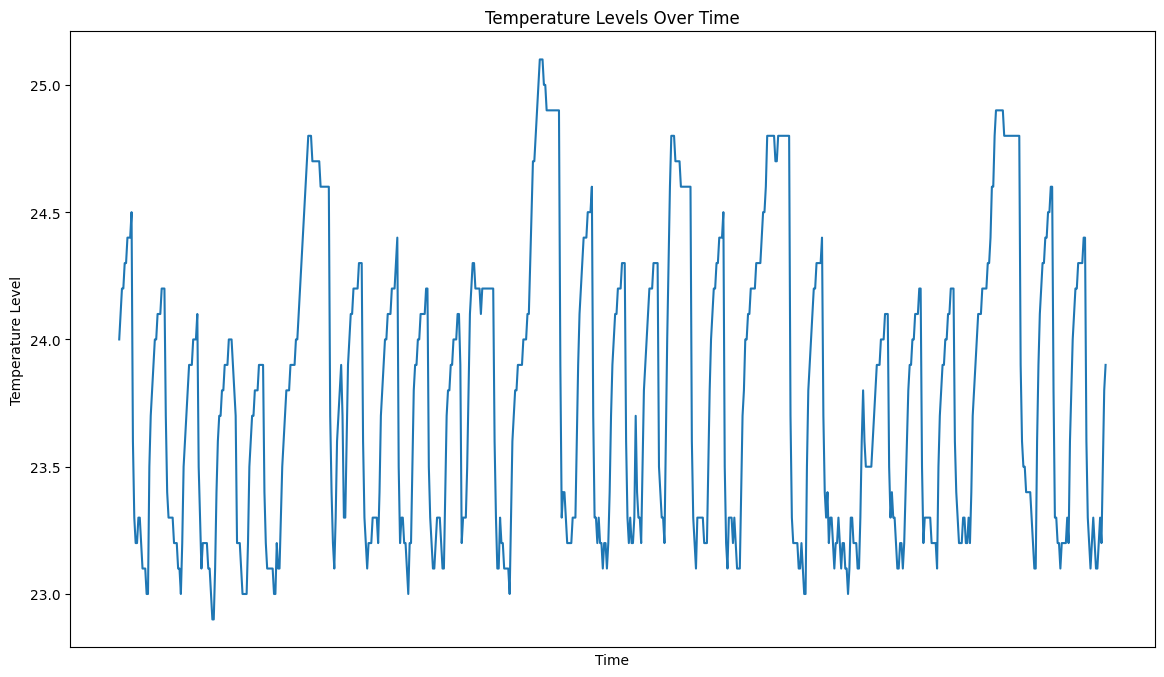

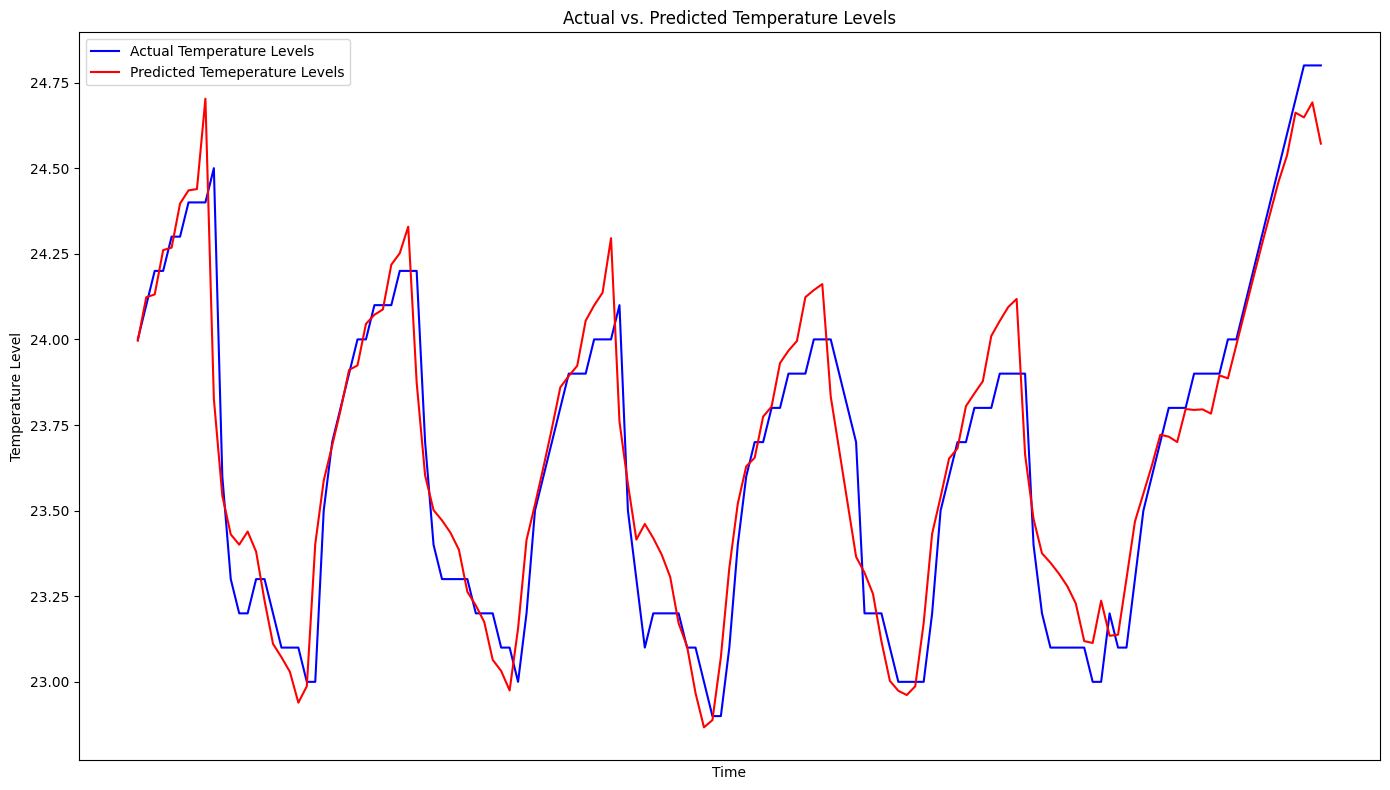

In [15]:
# Visualize the input data
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature Level')
plt.title('Temperature Levels Over Time')

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(data.index[0], data.index[-1], freq='H'), rotation=45)

plt.show()

# Visualize the predictions
plt.figure(figsize=(14, 8))

actual_dates = data.index[-len(y_test_actual):]  # This fetches the dates for the test segment

plt.plot(actual_dates, y_test_actual, label='Actual Temperature Levels', color='blue')
plt.plot(actual_dates, y_pred_actual, label='Predicted Temeperature Levels', color='red')

plt.xlabel('Time')
plt.ylabel('Temperature Level')
plt.title('Actual vs. Predicted Temperature Levels')
plt.legend()

# Set x-axis ticks to hourly intervals
plt.xticks(pd.date_range(actual_dates[0], actual_dates[-1], freq='H'), rotation=45)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()



In [16]:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = sqrt(mean_squared_error(y_test_actual, y_pred_actual))  # As calculated previously
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test MAPE: {mape}%')
print(f'Test R-Squared: {r2}')

Test MAE: 0.10960613223288562
Test RMSE: 0.14705799772317052
Test MAPE: 0.4642084019604805%
Test R-Squared: 0.9055039412653167


**Plotting Training and Validation Loss**

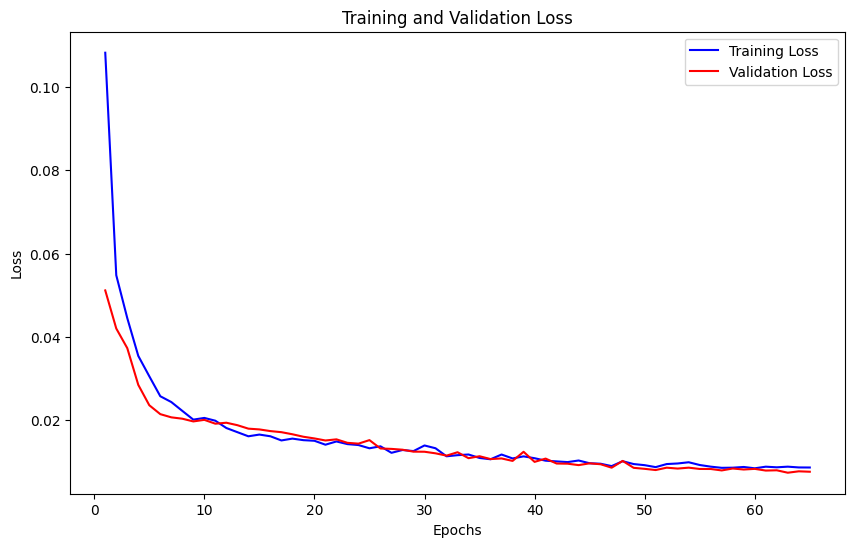

In [17]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Assuming you have an equal number of epochs for training and validation
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()